### LSTM neural network for time series

1. File volkswagen.csv contains daily stock trading info for Volkswagen AG in 2020 year. Open the file as pandas dataframe. Add to the dataframe a new column “Quantile”. It should take 4 possible values [1,2,3,4]. A value in this column is a quantile [0.25, 0.5, 0.75 or 1] of column “Volume” to which belong an appropriate row. Alternatively, it is also called 25th,50th,75th and 100th percentiles.  
Group dataframe by column Quantile to get mean values for all columns in every Quantile group. The output of grouping is dataframe itself. Save it as groups.csv file. 


2. Use again volkswagen.csv . You need columns “Close” and “Date”. Split “Close” time series on training/validation/test parts in proportion 70/20/10. Use training/validation data to train LSTM neural network. Normalize the data (e.g., with MinMaxScaler from scikit-learn library) before training. Train the model. The model should take several actual time series values to predict 1 future value. You can select arbitrary number of previous values to use for prediction. For example, you can train your model to make a prediction of xt based on previous 20 observations: xt-1, xt-2, …xt-20  (! Be sure that you predict based on previous values, not the future ones). Keep model architecture simple. It must contain at least one LSTM layer. Save trained model. Model’s explanatory power is not important. Don’t think here about accuracy etc. It should just work.   
Apply the model to test data, and get predictions. Plot actual test data and predicted test data on the same chart (for example, use matplotlib library). 
Please, write comments in your code
Provide all code, list of installed libraries (requirements.txt) and saved csv files


___

#### First task.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('volkswagen.csv')

In [3]:
df['Quantile'] = pd.qcut(df['Volume'], 4, labels=[1, 2, 3, 4])

In [4]:
df = df.groupby('Quantile', as_index=False).mean()

In [5]:
df

,Quantile,Open,High,Low,Close,Adj Close,Volume
0,1,17.724391,17.828625,17.578828,17.699734,16.894641,69523.437500
1,2,17.630794,17.771540,17.498587,17.651587,16.943300,111374.603175
2,3,17.122921,17.259095,16.918920,17.078968,16.426738,167992.063492
3,4,15.660619,15.895206,15.434159,15.682698,15.089721,324239.682540


In [6]:
df.to_csv('groups.csv', index=False)

___

#### Second task.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.simplefilter('ignore')

In [8]:
df = pd.read_csv('volkswagen.csv')

In [9]:
df = df.sort_values('Date')

Let's see what kind of data we have.

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-31,19.420000,19.420000,19.139999,19.290001,18.345758,25500
1,2020-01-02,19.667999,19.896999,19.639999,19.889999,18.916388,71000
2,2020-01-03,19.430000,19.540001,19.378000,19.410000,18.459883,35500
3,2020-01-06,19.360001,19.650000,19.330000,19.620001,18.659605,115300
4,2020-01-07,19.586000,19.700001,19.459999,19.520000,18.564501,181300


In [11]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
248,2020-12-23,20.500000,20.719999,20.400000,20.690001,20.325727,343100
249,2020-12-24,20.730000,20.850000,20.650000,20.830000,20.463261,124300
250,2020-12-28,20.840000,20.959999,20.799999,20.834000,20.467192,229800
251,2020-12-29,20.889999,20.889999,20.750000,20.820000,20.453438,103700
252,2020-12-30,21.070000,21.139999,20.870001,20.951000,20.582132,152600


In [12]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,17.037407,17.191146,16.860474,17.030901,16.340798,167892.094862
std,2.100543,2.042477,2.145014,2.102519,2.113286,117343.064805
min,11.120000,11.320000,10.600000,10.680000,10.157216,25500.000000
25%,15.990000,16.150000,15.880000,16.000000,15.264355,89200.000000
50%,17.200001,17.379999,17.059999,17.250000,16.602453,138700.000000
75%,18.559999,18.700001,18.459999,18.549999,17.718063,203300.000000
max,21.070000,21.139999,20.870001,20.951000,20.582132,907700.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       253 non-null    object 
 1   Open       253 non-null    float64
 2   High       253 non-null    float64
 3   Low        253 non-null    float64
 4   Close      253 non-null    float64
 5   Adj Close  253 non-null    float64
 6   Volume     253 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


Now let's have a brief look at our data.

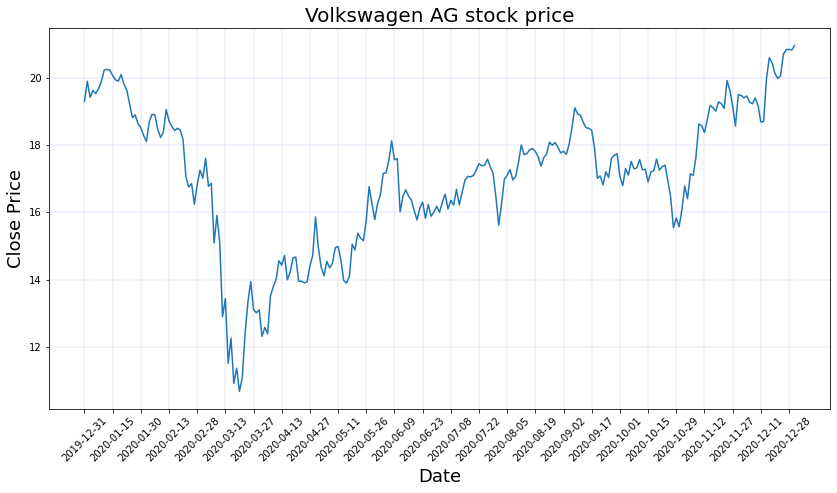

In [14]:
plt.figure(figsize = (14, 7))
plt.plot(range(df.shape[0]), (df['Close']))
plt.xticks(range(0,df.shape[0], 10), df['Date'].loc[::10], rotation = 45)
plt.title('Volkswagen AG stock price', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

Time to prepare our data a little bit. Now we need only the 'Close' column.

In [15]:
data = df.iloc[:, 4:5].values

Then let's split our data to training/validation/test parts, normalize'em.

In [16]:
data_train, data_valid = train_test_split(data, shuffle=False, test_size=0.3)
data_valid, data_test = train_test_split(data_valid, shuffle=False, test_size=0.33)

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))

To prevent the data leakage we fit scaler only on data_train.

In [18]:
scaler.fit(data_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
def scale_and_create_dataset(dataset, lookback, test=False):
    
    '''The function scales provided dataset and makes lists of features and targets.'''
    
    data = scaler.transform(dataset)
    features, targets = [], []
    if test == False:
        for i in range(lookback, len(data)):
            features.append(data[i-lookback:i, 0])
            targets.append(data[i, 0])
    else:
        for i in range(lookback, len(data)):
            features.append(data[i-lookback:i, 0])
            targets.append(dataset[i, 0])
    return np.array(features), np.array(targets)

Just checked - we definetly predict based on previous values.

In [20]:
x_train, y_train = scale_and_create_dataset(data_train, lookback=4)

In [21]:
x_valid, y_valid = scale_and_create_dataset(data_valid, lookback=4)

In [22]:
x_test, y_test = scale_and_create_dataset(data_test, lookback=4, test=True)

Reshape input to be (samples, lookback, features) which is required for LSTM layers.

In [23]:
def reshape_dataset(dataset):
    
    '''The function just reshapes dataset.'''
    
    return np.reshape(dataset, (dataset.shape[0], dataset.shape[1], 1))

In [24]:
x_train = reshape_dataset(x_train)

In [25]:
x_valid = reshape_dataset(x_valid)

In [26]:
x_test = reshape_dataset(x_test)

And now it's time to create neural network with LSTM layers. Simple as possible.

In [27]:
def create_model(input_shape):
    
    '''
        The function creates neural network model with provided layers. 
        Input shape - shape of the lookback-array.
    
    '''
    model = Sequential()

    model.add(LSTM(units = 10, return_sequences=True,
               kernel_initializer='glorot_uniform',
               input_shape=input_shape))

    model.add(LSTM(units=10, kernel_initializer='glorot_uniform',
               return_sequences=True))

    model.add(LSTM(units=10, kernel_initializer='glorot_uniform'))

    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

To create model we need to specify the input shape, let's do it.

In [28]:
input_shape = (x_train.shape[1], 1)

In [29]:
model = create_model(input_shape)

In [30]:
def train_model(model, features, target, validation_data, batch_size=None, epochs=None):
    
    '''The function trains neural network model. Also creates a file with weights of the best model.'''

    weights_file = 'weights.hdf5'
    metric = 'val_loss'
    checkpoint = ModelCheckpoint(weights_file, monitor=metric, mode='min', save_best_only=True, verbose=2)

    model.fit(features, target, validation_data=validation_data, 
              batch_size=batch_size, epochs=epochs, 
              callbacks=[checkpoint], shuffle=False)

    return model

In [31]:
# model = train_model(model, features=x_train, target=y_train, 
#                    batch_size=10, epochs=20, validation_data=(x_valid, y_valid))

From this time we don't need to retrain our model again.

In [32]:
model.load_weights('weights.hdf5')

Final step, applying the model to test data and getting predictions.

In [33]:
y_pred = model(x_test)

In [34]:
predicted_price = scaler.inverse_transform(y_pred)

Let's see what we've got.

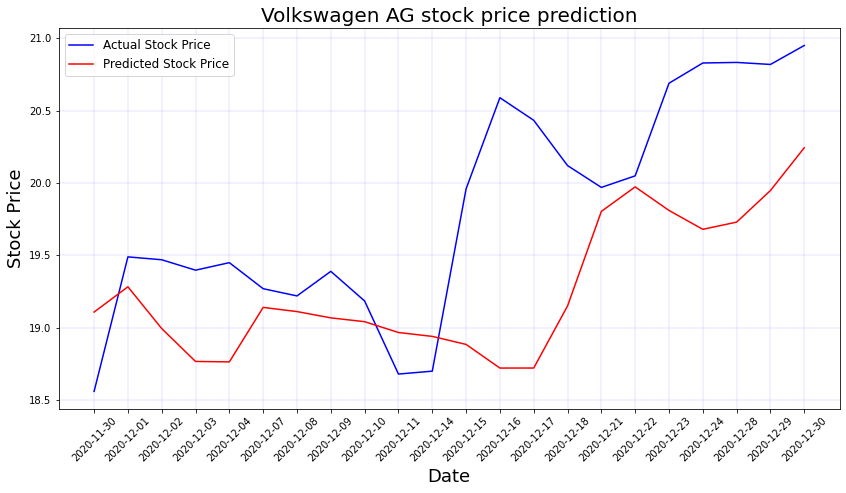

In [35]:
plt.figure(figsize = (14, 7))
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.xticks(range(0, y_test.shape[0], 1), df['Date'].iloc[227+data_train.shape[0]-x_train.shape[0]::1], rotation = 45)
plt.title('Volkswagen AG stock price prediction', fontsize=20)
plt.xlabel('Date',  fontsize=18)
plt.ylabel('Stock Price', fontsize=18)
plt.legend(fontsize=12)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

Summarizing, we just made the neural network with couple of LSTM layers, and it seems like it works.

___